**THIS NOTEBOOKS CONTAINS EXPLORATARY FORECASTING OF AMOUNT OF SELLERS FOR WHOM ARIMA MODEL IS NOT SUITABLE.**

**To prepare ARIMA there should be at least 100 observations for forecasting the model.**
https://www.researchgate.net/post/What_should_be_the_minimum_number_of_observations_for_a_time_series_model

**COUNT WISE SELLERES**

In [116]:
uniq=[]
for k in dump.SellerId.unique():
    uniq.append(len(dump[dump.SellerId==k]))    
count_wise_sellers=pd.DataFrame(uniq, index=dump.SellerId.unique(), columns=["Count"])
count_wise_sellers

,Count
13,645
10,18020
16,948
6,32
8,1541
20,2271
19,2
9,2742
11,3944
14,2463


*From above output we can conclude that sellers 1,3 and 6 are having inadequate frequecy to be considered for application of ARIMA model* 

<font color="red"> **FORECAST FOR SELLER_6**</font>

In [6]:
#Importing the prerequisite libraries that are to be used further.
import pandas as pd
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
import matplotlib.pyplot as plt

**Below is our original csv file**

In [7]:
dump=pd.read_csv("dump.csv")

In [8]:
dump.head(10)

,Unnamed: 0,Id,TransactionDate,DueDate,DateFullyPaid,SellerId,BuyerId,Amount,Balance,Deposit,...,SalesTerm,Estimate,sel_id,sel_orgtype,sel_Business_type,sel_fiscal_year_start_month,buy_id,buy_first_engaged,buy_most_recent_engaged,buy_prev_engaged
0,0,379967,2019-03-15T00:00:00.000Z,2019-04-14T00:00:00.000Z,NaN,19,53484,10000,10000,0,...,NaN,NaN,19,NaN,NaN,January,53484,2017-04-18T00:00:00.000Z,2019-03-15T00:00:00.000Z,2019-03-15T00:00:00.000Z
1,1,379968,2017-04-18T00:00:00.000Z,2017-05-18T00:00:00.000Z,NaN,19,53484,5000000,5000000,0,...,NaN,NaN,19,NaN,NaN,January,53484,2017-04-18T00:00:00.000Z,2019-03-15T00:00:00.000Z,2019-03-15T00:00:00.000Z
2,2,379969,2019-07-18T00:00:00.000Z,2019-08-17T00:00:00.000Z,NaN,1,53487,5000,0,0,...,NaN,NaN,1,Limited Liability,Manufacturing Businesses,January,53487,2019-07-18T00:00:00.000Z,2019-07-18T00:00:00.000Z,2019-07-18T00:00:00.000Z
3,3,379970,2019-07-18T00:00:00.000Z,2019-08-17T00:00:00.000Z,NaN,1,53488,13000,0,0,...,NaN,NaN,1,Limited Liability,Manufacturing Businesses,January,53488,2019-07-18T00:00:00.000Z,2019-07-18T00:00:00.000Z,2019-07-18T00:00:00.000Z
4,4,379971,2019-07-18T00:00:00.000Z,2019-08-17T00:00:00.000Z,NaN,1,53488,17500,0,0,...,NaN,NaN,1,Limited Liability,Manufacturing Businesses,January,53488,2019-07-18T00:00:00.000Z,2019-07-18T00:00:00.000Z,2019-07-18T00:00:00.000Z
5,5,379972,2019-07-18T00:00:00.000Z,2019-08-17T00:00:00.000Z,NaN,1,53489,14500,0,0,...,NaN,NaN,1,Limited Liability,Manufacturing Businesses,January,53489,2019-07-18T00:00:00.000Z,2019-07-18T00:00:00.000Z,2019-07-18T00:00:00.000Z
6,6,379973,2019-07-18T00:00:00.000Z,2019-08-17T00:00:00.000Z,NaN,1,53489,2600,0,0,...,NaN,NaN,1,Limited Liability,Manufacturing Businesses,January,53489,2019-07-18T00:00:00.000Z,2019-07-18T00:00:00.000Z,2019-07-18T00:00:00.000Z
7,7,379974,2018-12-10T00:00:00.000Z,2019-01-09T00:00:00.000Z,NaN,1,53490,19900,19900,0,...,NaN,NaN,1,Limited Liability,Manufacturing Businesses,January,53490,2018-12-10T00:00:00.000Z,2018-12-10T00:00:00.000Z,2018-12-10T00:00:00.000Z
8,8,379975,2018-12-01T00:00:00.000Z,2018-12-31T00:00:00.000Z,NaN,1,53491,1900,100,0,...,NaN,NaN,1,Limited Liability,Manufacturing Businesses,January,53491,2018-11-01T00:00:00.000Z,2018-12-01T00:00:00.000Z,2018-12-01T00:00:00.000Z
9,9,379976,2018-11-01T00:00:00.000Z,2018-12-01T00:00:00.000Z,NaN,1,53491,1900,0,0,...,NaN,NaN,1,Limited Liability,Manufacturing Businesses,January,53491,2018-11-01T00:00:00.000Z,2018-12-01T00:00:00.000Z,2018-12-01T00:00:00.000Z


**Following code prepares the time series with index as the Transaction Time and value as amount.**

In [9]:
sel=dump[dump.SellerId==6][["TransactionDate","Amount"]]
sel["TransactionDate"]=sel.TransactionDate.apply(lambda x: x.split("T")[0])
sel["TransactionDate"]=pd.to_datetime(sel.TransactionDate)
sel=sel.set_index("TransactionDate")
sel = sel.groupby(pd.Grouper(freq="M")).sum()
sel["Amount"]=sel.Amount.apply(lambda x:int(x))
ts=sel["Amount"]

In [10]:
ts.tail()

TransactionDate
2019-01-31    27874703
2019-02-28     8196776
2019-03-31    16854217
2019-04-30    16455700
2019-05-31    24076179
Freq: M, Name: Amount, dtype: int64

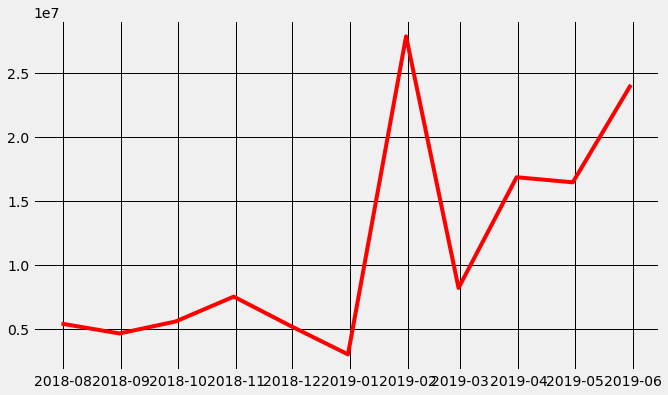

In [11]:
plt.figure(figsize=(10,6))
plt.plot(ts, color="red")
plt.grid(True, color="black")
plt.show()

**Following function is created to test the statioarity of time series, It includes the dickey fuller test.**

In [12]:
from statsmodels.tsa.stattools import adfuller
def dft(ts):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

**Testing for stationarity**

In [13]:
dft(ts)

Results of Dickey-Fuller Test:
Test Statistic                -0.000000
p-value                        0.958532
#Lags Used                     4.000000
Number of Observations Used    6.000000
Critical Value (1%)           -5.354256
Critical Value (5%)           -3.646238
Critical Value (10%)          -2.901198
dtype: float64


*The test_stats is greater than critical values. Hence the series is non stationary.*

**Below is logarithmic transformation of the series which will make little stationary in comparison to non transformed data.**

In [14]:
ts_log=np.log(ts)

**Testing for stationary**

In [15]:
dft(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                 0.000000
p-value                        0.958532
#Lags Used                     4.000000
Number of Observations Used    6.000000
Critical Value (1%)           -5.354256
Critical Value (5%)           -3.646238
Critical Value (10%)          -2.901198
dtype: float64


**Here the series is still non stationary**

*Differencing is applied to reduce trend and seasonality from tha data.*

In [16]:
ts_log_diff=ts_log-ts_log.shift()

*Removal of nan values from differencing output*

In [17]:
ts_log_diff.dropna(inplace=True)

**Testing for stationarity**

In [18]:
dft(ts_log_diff)

Results of Dickey-Fuller Test:
Test Statistic                -5.959956e+00
p-value                        2.050242e-07
#Lags Used                     0.000000e+00
Number of Observations Used    9.000000e+00
Critical Value (1%)           -4.473135e+00
Critical Value (5%)           -3.289881e+00
Critical Value (10%)          -2.772382e+00
dtype: float64


**Now the test_stats is less 1% critical values i.e. the series is stationary with 99% confidence.**

**APPLYING MOVING AVERAGE MODEL**

In [26]:
from statsmodels.tsa.arima_model import ARMA
model = ARMA(ts_log_diff, order=(0, 1))
model_fit = model.fit(disp=False)

In [27]:
ts_log_diff.head(10)

TransactionDate
2018-08-31   -0.154166
2018-09-30    0.184376
2018-10-31    0.298941
2018-11-30   -0.358848
2018-12-31   -0.559773
2019-01-31    2.229107
2019-02-28   -1.223979
2019-03-31    0.720860
2019-04-30   -0.023929
2019-05-31    0.380551
Freq: M, Name: Amount, dtype: float64

**Predicting amount for coming 6 months**

In [28]:
pred_mean=model_fit.predict(start="2019-05-31",end="2019-12-31")

**Following is the reverse transformation steps to have the forecast into original time series format.**

In [29]:
predictions_ARIMA_diff = pd.Series(pred_mean, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
a=ts_log[-1]
b=a+predictions_ARIMA_diff_cumsum
predictions_ARIMA = np.exp(b)

In [30]:
forecast=pd.DataFrame()
forecast["amount"]=predictions_ARIMA
forecast["amount"]=forecast.amount.apply(lambda x:int(x))

**Below is the forecasted amount**

In [31]:
forecast.amount

2019-05-31    28286267
2019-06-30    26677844
2019-07-31    31333504
2019-08-31    36801641
2019-09-30    43224046
2019-10-31    50767251
2019-11-30    59626851
2019-12-31    70032576
Freq: M, Name: amount, dtype: int64

**Below is the plot containing our original data and the forecasted values together.**

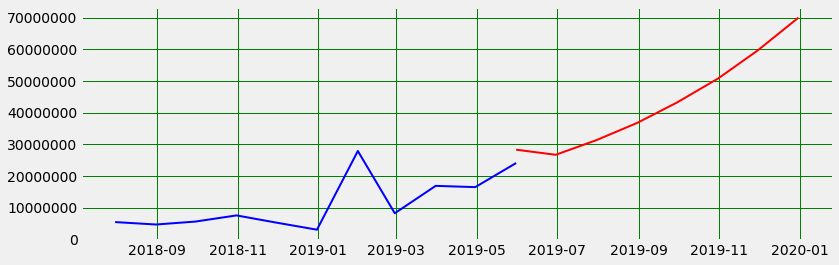

In [32]:
plt.figure(figsize=(12,4))
plt.plot(ts, color="blue", linewidth=2)
plt.plot(forecast.amount,color="red", linewidth=2)
plt.gca().get_yaxis().get_major_formatter().set_scientific(False)
plt.grid(True, color="green")

<font color="red"> **FORECAST FOR SELLER_3**</font>

**In upcoming codes seller_3 is taken under consideration**

In [42]:
dump=pd.read_csv("dump.csv")

**This function takes input as the seller number and gives output the time series well prepared after multiple processes.**

In [43]:
def ts_seller_wise(k):
    sel=dump[dump.SellerId==k][["TransactionDate","Amount"]]
    sel["TransactionDate"]=sel.TransactionDate.apply(lambda x: x.split("T")[0])
    sel["TransactionDate"]=pd.to_datetime(sel.TransactionDate)
    sel=sel.set_index("TransactionDate")
    sel = sel.groupby(pd.Grouper(freq="M")).sum()
    sel["Amount"]=sel.Amount.apply(lambda x:int(x))
    ts=sel["Amount"]
    return ts

**Time series for seller_3**

In [44]:
ts=ts_seller_wise(3)

In [45]:
ts

TransactionDate
2018-09-30       2400
2018-10-31     149220
2018-11-30     147300
2018-12-31     118320
2019-01-31     578218
2019-02-28    1146459
2019-03-31       4400
2019-04-30       9600
2019-05-31          0
2019-06-30     262169
2019-07-31      11880
Freq: M, Name: Amount, dtype: int64

**Test of stationarity**

In [46]:
dft(ts)

Results of Dickey-Fuller Test:
Test Statistic                 -0.000000
p-value                         0.958532
#Lags Used                      7.000000
Number of Observations Used     3.000000
Critical Value (1%)           -10.417191
Critical Value (5%)            -5.778381
Critical Value (10%)           -3.391681
dtype: float64


*The output depicts that time series is non stationary.*

**Following is the application of differencing to make the series stationary.**

In [47]:
ts_diff=ts-ts.shift()

*Removing the na values created during differencing.*

In [48]:
ts_diff.dropna(inplace=True)

**Testing for stationarity.**

In [49]:
dft(ts_diff)

Results of Dickey-Fuller Test:
Test Statistic                -3.355261
p-value                        0.012582
#Lags Used                     0.000000
Number of Observations Used    9.000000
Critical Value (1%)           -4.473135
Critical Value (5%)           -3.289881
Critical Value (10%)          -2.772382
dtype: float64


*The series is now stationary with 95 % confidence*.

**Following function takes the forecasted amount as input and converts it into a plot added with plot of original time series.**

In [50]:
def forc_amou(pred_mean):
    predictions_ARIMA_diff = pd.Series(pred_mean, copy=True)
    predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
    a=ts_log[-1]
    predictions_ARIMA=a+predictions_ARIMA_diff_cumsum
    forecast=pd.DataFrame()
    forecast["amount"]=predictions_ARIMA
    forecast["amount"]=forecast.amount.apply(lambda x:int(x))
    plt.figure(figsize=(12,4))
    plt.plot(ts, color="blue", linewidth=2)
    plt.plot(forecast.amount,color="red", linewidth=2)
    plt.gca().get_yaxis().get_major_formatter().set_scientific(False)
    plt.grid(True, color="green")

**AUTOREGRESSIVE MODEL_3**  
*This model forecast by using the regression of current item with past few items.*

In [51]:
from statsmodels.tsa.ar_model import AR
model = AR(ts_diff)
model_fit = model.fit()
pred_mean_autoreg=model_fit.predict(start="2019-07-31", end="2019-12-31")

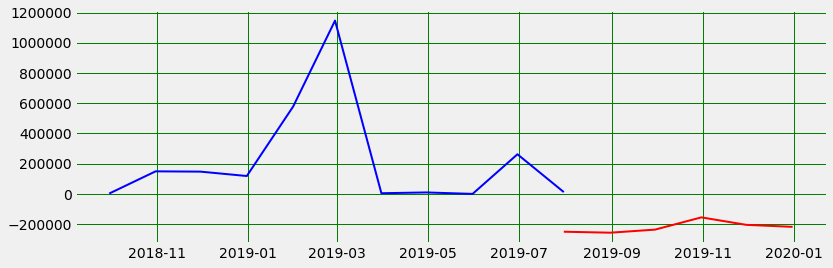

In [52]:
forc_amou(pred_mean_autoreg)

*Above is the forecast of amount using auto regressive model.*

**SIMPLE EXPONENTIAL MODEL_3**  
> *This model is simple exponential smoothing of the series. It computes the exponential mean of given data and forecast the same for any duration.*

*Below code is for computing the forecast of amount for coming 6 months using simple exponential smoothing.*

In [53]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
model = SimpleExpSmoothing(ts_diff)
model_fit = model.fit()
pred_simple_exponential=model_fit.predict(start="2019-07-31", end="2019-12-31")

**Following is the plot portraying the forecast of amount using simple exponential smoothing.**

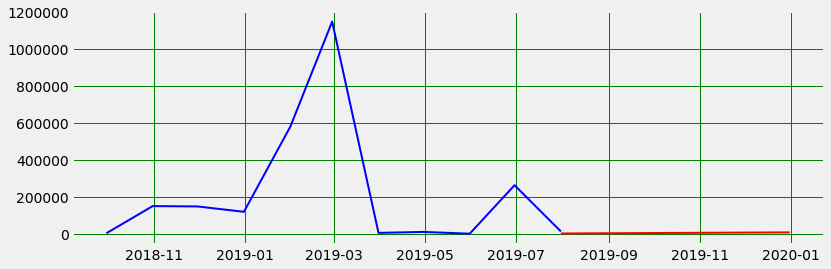

In [54]:
forc_amou(pred_simple_exponential)

**MOVING AVERAGE_3**

**This is moving average model which consideres the mean of preceding items to forecast the future values.**

In [55]:
from statsmodels.tsa.arima_model import ARMA
model = ARMA(ts_diff, order=(0,1))
model_fit = model.fit()
pred_mean_moving_avg=model_fit.predict(start="2019-07-31", end="2019-12-31")

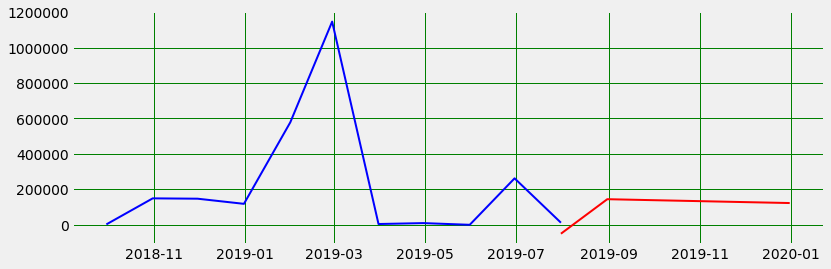

In [56]:
forc_amou(pred_mean_moving_avg)

**AUTOREGRESSIVE MOVING AVERAGE_3**

**This is auto regressive model which performs regression on lagged values of the series.**

In [57]:
from statsmodels.tsa.arima_model import ARMA
model = ARMA(ts_diff, order=(2,1))
model_fit = model.fit()
pred_mean_autoreg_movingavg=model_fit.predict(start="2019-07-31", end="2019-12-31")

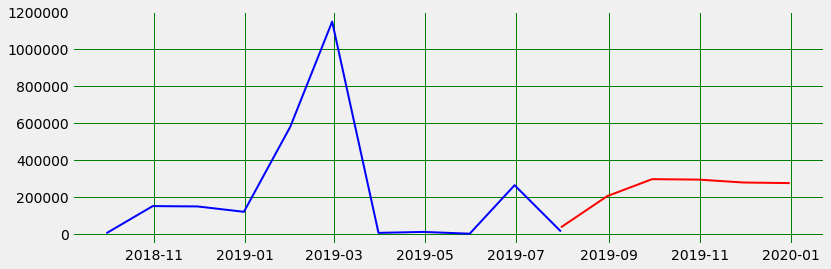

In [58]:
forc_amou(pred_mean_autoreg_movingavg)

**HOLTS LINEAR EXPONENTIAL SMOOTHING_3**  
*This is holts linear smoothing which is a modification of exponential smoothing*

In [59]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model = ExponentialSmoothing(ts)
model_fit = model.fit()
pred_mean_holtslinear_exponential_smoothing=model_fit.predict(start="2019-07-31", end="2019-12-31")

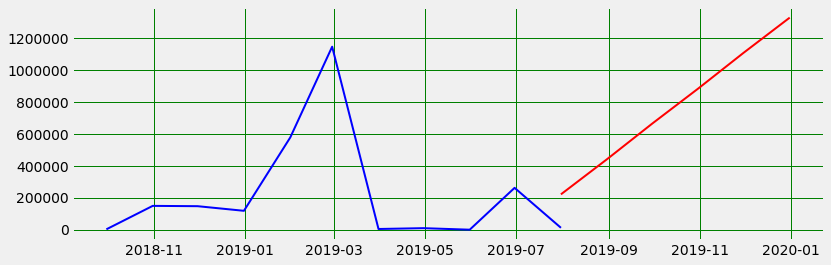

In [60]:
forc_amou(pred_mean_holtslinear_exponential_smoothing)

<font color="red"> **FORECAST FOR SELLER_19** </font>

**Below code will consider seller 19.**  
*Seller_19 has only two positive values. So for this seller the naive mean of two given amounts have been plotted for coming 6 months.*

*This code creates a pandas series of datetime indices for coming 6 months.*

In [61]:
from datetime import datetime
date_rng = pd.date_range(start=pd.to_datetime('2019-07-31'), end=pd.to_datetime("2019-12-31"), freq='M')

In [62]:
date_rng

DatetimeIndex(['2019-07-31', '2019-08-31', '2019-09-30', '2019-10-31',
               '2019-11-30', '2019-12-31'],
              dtype='datetime64[ns]', freq='M')

**Following is the time series of seller_19**

In [63]:
ts_19=ts_seller_wise(19)

In [64]:
ts_19.head()

TransactionDate
2017-04-30    5000000
2017-05-31          0
2017-06-30          0
2017-07-31          0
2017-08-31          0
Freq: M, Name: Amount, dtype: int64

*Below is mena of amount of given time series which will be forecasted for coming 6 months.*

In [65]:
naive_seller_19=dump[dump.SellerId==19].Amount.mean()

*This is a dataframe containing the amount with the indices to be forecasted.*

In [66]:
df=pd.DataFrame(index=date_rng)
df["amount"]=naive_seller_19

**NAIVE MEAN MODEL SELLER_19**

This is plotting of time series.

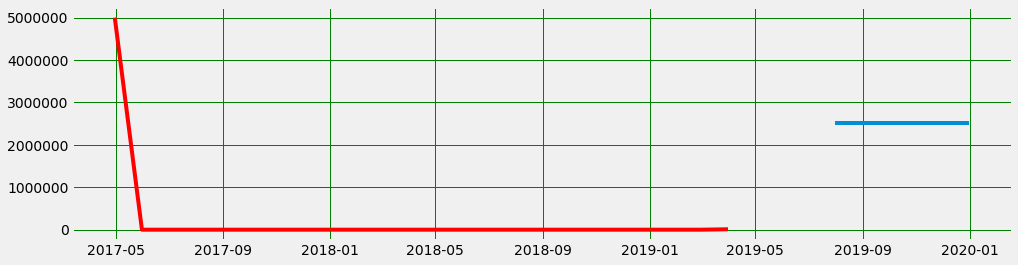

In [67]:
plt.figure(figsize=(15,4))
plt.plot(df)
plt.plot(ts_19, color="red")
plt.grid(True, color="green")

<font color="red"> **FORECAST FOR SELLER_1** </font>

**Below code will consider seller 1.**

In [68]:
ts_1=ts_seller_wise(1)

In [69]:
ts_1

TransactionDate
2018-11-30     1900
2018-12-31    21800
Freq: M, Name: Amount, dtype: int64

*It also has two values. So naive mean will be suitable model for this data too.*

*This code creates a pandas series of datetime indices for coming 6 months.*

In [70]:
from datetime import datetime
date_rng = pd.date_range(start=pd.to_datetime('2019-07-31'), end=pd.to_datetime("2019-12-31"), freq='M')

**Following is the forecast of coming 6 months.**

In [71]:
naive_seller_1=dump[dump.SellerId==1].Amount.mean()

In [72]:
df=pd.DataFrame(index=date_rng)
df["amount"]=naive_seller_1

**NAIVE MEAN MODEL SELLER_1**

**This plot portrays the original and forecasted values for coming 6 monhts.**

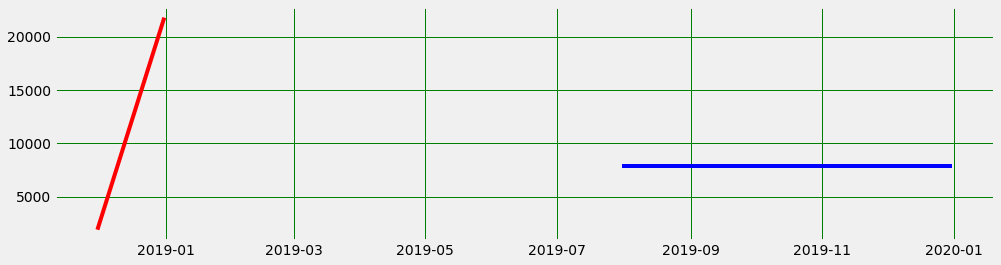

In [73]:
plt.figure(figsize=(15,4))
plt.plot(df, color="blue")
plt.plot(ts_1, color="red")
plt.grid(True, color="green")

In [74]:
sel_13=ts_seller_wise(13)

In [75]:
sel_13

TransactionDate
2015-12-31      554937
2016-01-31      572900
2016-02-29      547166
2016-03-31      992872
2016-04-30      822866
2016-05-31      794288
2016-06-30     1419390
2016-07-31     1677551
2016-08-31     1396583
2016-09-30     1638827
2016-10-31     1697679
2016-11-30     1449077
2016-12-31     1875656
2017-01-31     1935535
2017-02-28     2212570
2017-03-31     2043657
2017-04-30     2430513
2017-05-31     1871103
2017-06-30     2690457
2017-07-31     2328646
2017-08-31     2500392
2017-09-30     2973578
2017-10-31     4012908
2017-11-30     3724928
2017-12-31     4058546
2018-01-31     4633740
2018-02-28     5220998
2018-03-31     4901415
2018-04-30     4721591
2018-05-31     5073155
2018-06-30     6486643
2018-07-31     6476681
2018-08-31     7419291
2018-09-30     6816976
2018-10-31    11555555
2018-11-30    12608596
2018-12-31    14363057
2019-01-31    12699160
2019-02-28    12959233
2019-03-31    14704647
2019-04-30    17594896
2019-05-31    14135376
2019-06-30    1286

In [76]:
train=sel_13.iloc[:35]
test=sel_13.iloc[35:]

In [77]:
test

TransactionDate
2018-11-30    12608596
2018-12-31    14363057
2019-01-31    12699160
2019-02-28    12959233
2019-03-31    14704647
2019-04-30    17594896
2019-05-31    14135376
2019-06-30    12863813
Freq: M, Name: Amount, dtype: int64